In [65]:
from typing import TypedDict, Annotated, Optional
from langgraph.graph import add_messages,StateGraph, END
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities import SearxSearchWrapper
from dotenv import load_dotenv
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_google_genai import ChatGoogleGenerativeAI
from uuid import uuid4
from langchain_core.tools import Tool
from langchain_core.tools import tool
from langchain_groq import ChatGroq
import json

load_dotenv()

model = ChatGroq(
    model="llama3-70b-8192",
    temperature=0.1,
)

response = model.invoke("who are you?")
response

AIMessage(content="I am LLaMA, an AI assistant developed by Meta AI that can understand and respond to human input in a conversational manner. I'm not a human, but a computer program designed to simulate conversation, answer questions, and even generate text based on the input I receive.\n\nI'm a large language model, which means I've been trained on a massive dataset of text from various sources, including books, articles, and online conversations. This training enables me to understand and respond to a wide range of topics and questions.\n\nI'm here to help, inform, and even entertain you. So, feel free to ask me anything, and I'll do my best to provide a helpful and accurate response!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 142, 'prompt_tokens': 14, 'total_tokens': 156, 'completion_time': 0.405714286, 'prompt_time': 0.000196886, 'queue_time': 0.048992727, 'total_time': 0.405911172}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd

In [66]:
search_tool_instance = TavilySearchResults(max_results=2)
search_tool = Tool.from_function(
    func=search_tool_instance.run,
    name="tavily_search_results_json",
    description="Search the web using Tavily and return top results."
)
tools = [search_tool]
memory = MemorySaver()


In [67]:
llm_with_tools = model.bind_tools(tools=[search_tool])



In [69]:
llm_with_tools.invoke("what is the weather today in Junagadh?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fpws', 'function': {'arguments': '{"__arg1":"Junagadh weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 907, 'total_tokens': 959, 'completion_time': 0.180907214, 'prompt_time': 0.029639476, 'queue_time': 0.049975536, 'total_time': 0.21054669}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--74aa73d5-3b9d-407c-8eac-8073bac60146-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'__arg1': 'Junagadh weather'}, 'id': 'call_fpws', 'type': 'tool_call'}], usage_metadata={'input_tokens': 907, 'output_tokens': 52, 'total_tokens': 959})

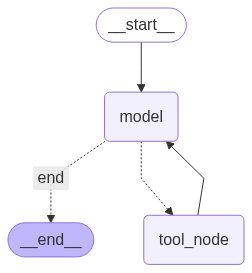

In [71]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
from langgraph.prebuilt import ToolNode

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: State):
    result = await llm_with_tools.ainvoke(state["messages"])
    return {
        "messages": [result], 
    }

async def tools_router(state: State):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return "end"
    
tool_node = ToolNode(tools=tools)

graph_builder = StateGraph(State)

graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges(
    "model",
    tools_router,
    {
        "tool_node":"tool_node",
        "end":END
    })
graph_builder.add_edge("tool_node", "model")

graph = graph_builder.compile(checkpointer=memory)
graph

In [72]:
config = {
    "configurable": {
        "thread_id": "5"
    }
}

response = await graph.ainvoke({
    "messages": [HumanMessage(content="When is the next spaceX launch?")], 
}, config=config)

response

{'messages': [HumanMessage(content='When is the next spaceX launch?', additional_kwargs={}, response_metadata={}, id='81673733-e685-4dfc-99f9-72af02fd8804'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_h0av', 'function': {'arguments': '{"__arg1":"SpaceX launch schedule"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 905, 'total_tokens': 958, 'completion_time': 0.152692992, 'prompt_time': 0.036883185, 'queue_time': 0.050817984999999996, 'total_time': 0.189576177}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b0595f6c-9548-4753-bfc4-bc563f865a31-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'__arg1': 'SpaceX launch schedule'}, 'id': 'call_h0av', 'type': 'tool_call'}], usage_metadata={'input_tokens': 905, 'output_tokens': 53, 'total_tokens': 958}),
  ToolMessage(cont

In [78]:
config = {
    "configurable":{
        "thread_id":"6"
    }
}


async for event in graph.astream_events({
    "messages":[HumanMessage(content="write me an email about job openings at aviato in AI engineer.")]
},config=config,version="v2"):
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content,end="",flush=True)
    # print(event)

Here is an email about job openings at Aviato in AI Engineer:

Subject: Exciting AI Engineer Job Opportunities at Aviato

Dear [Recipient],

I hope this email finds you about an incredible opportunity to take your AI engineering skills to new heights! Aviato, a pioneering company in the field of Artificial Intelligence, is currently seeking talented AI Engineers like you to join our innovative journey.

As an AI Engineer at Aviato, you will be responsible for designing, developing, and deploying cutting-edge AI models that drive business growth and transform industries. Our team is dedicated to pushing the boundaries, and we're looking for passionate individuals who share our vision and are eager to contribute to the development of AI solutions that make a real impact.

Some of the key responsibilities of an AI Engineer at Aviato include:

* Developing and deploying AI models, including machine learning and deep learning models
* Collaborating with cross-functional teams to integrate A